In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O
import os
import random
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from matplotlib.patches import Rectangle

SEED=42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
def _generate_anomaly_indices_and_lengths(rng, series_len,
                                          anom_type=4,
                                          length_params=None,
                                          existing_indices=None):
    """
    Generate non-overlapping anomaly start indices and lengths for injecting synthetic anomalies
    into a time series.

    Parameters
    ----------
    rng : np.random.Generator
        A NumPy random generator instance used for reproducibility.
    series_len : int
        Length of the time series.
    anom_type : int, default 4
        Anomaly type identifier. Supports:
          - 4: point anomalies (length = 1)
          - 2: block anomalies with lengths ∈ [2, 5] until total anomalous points reached
    length_params : dict, required
        Dictionary with keys:
            - 'min': float. Minimum % of series to be anomalous.
            - 'max': float. Maximum % of series to be anomalous.
    existing_indices : set of int, optional
        Set of indices that are already marked as anomalous. Ensures new anomalies don't overlap.

    Returns
    -------
    indices : np.ndarray of int
        Array of starting indices for anomalies.
    lengths : np.ndarray of int
        Corresponding lengths of each anomaly block.

    Example
    -------
    >>> rng = np.random.default_rng(42)
    >>> idxs, lens = _generate_anomaly_indices_and_lengths(
    ...     rng, 1000, anom_type=2, length_params={'min': 1, 'max': 2}, existing_indices=set())
    """
    if existing_indices is None:
        existing_indices = set()

    # Determine total number of anomalous points (across all blocks)
    min_samples = int(series_len * length_params['min'] / 100)
    max_samples = int(series_len * length_params['max'] / 100)
    total_samples = rng.choice(range(min_samples, max_samples))
    print(f"Targeting {total_samples} anomalous time steps")

    # Prepare sequence lengths
    if anom_type == 4:
        all_seq_lengths = np.ones(total_samples, dtype=int)

    elif anom_type == 2:
        # Segment the total_samples into variable-length blocks (e.g., lengths between 2 and 5)
        seq_min, seq_max = 2, 5
        all_seq_lengths = []
        remaining = total_samples
        while remaining > 0:
            high = min(seq_max + 1, remaining + 1)
            if seq_min >= high:
                break  # Cannot generate more valid segments
            choice = rng.integers(seq_min, high)
            all_seq_lengths.append(choice)
            remaining -= choice
        all_seq_lengths = np.array(all_seq_lengths, dtype=int)
        print(f"Planned {len(all_seq_lengths)} anomaly segments")

    else:
        raise NotImplementedError(f"Anomaly type {anom_type} not supported.")

    # Place segments without overlap
    indices = []
    count = len(all_seq_lengths)
    max_attempts = count * 10
    attempts = 0
    possible_start_indices = np.arange(series_len)

    while len(indices) < count and attempts < max_attempts:
        attempts += 1
        potential_length = all_seq_lengths[len(indices)]
        max_valid_start = series_len - potential_length

        if max_valid_start < 0:
            warnings.warn(f"Anomaly length ({potential_length}) > series length ({series_len}). Skipping.")
            continue

        valid_start_indices = possible_start_indices[possible_start_indices <= max_valid_start]
        if len(valid_start_indices) == 0:
            break

        potential_start = rng.choice(valid_start_indices)
        potential_end = potential_start + potential_length

        # Overlap check
        is_overlapping = any(idx in existing_indices for idx in range(potential_start, potential_end))
        if not is_overlapping:
            indices.append(potential_start)
            existing_indices.update(range(potential_start, potential_end))

    if len(indices) < count:
        warnings.warn(f"Could only place {len(indices)} out of {count} requested anomaly blocks.")
        all_seq_lengths = all_seq_lengths[:len(indices)]

    return np.array(indices, dtype=int), np.array(all_seq_lengths, dtype=int)


In [3]:
def _apply_labels(labels, indices, lengths, label_value):
    """
    Apply a specific label value to defined ranges in a label array.

    This function modifies a label array in-place by assigning `label_value` to
    specific ranges defined by `indices` (start positions) and `lengths`.

    Parameters
    ----------
    labels : np.ndarray or list-like
        The label array to update. Typically a 1D array of 0s that marks normal data.
    indices : array-like of int
        Start indices of segments to be labeled.
    lengths : array-like of int
        Lengths of each segment (must match indices in length).
    label_value : int or float
        Value to apply to the specified ranges (e.g., 1 for anomalies).

    Returns
    -------
    labels : np.ndarray
        The updated label array with specified segments set to `label_value`.

    Notes
    -----
    - This function safely handles boundary conditions: if a segment would go beyond
      the array length, it is truncated to fit within bounds.
    - It modifies the input `labels` array in-place and also returns it for convenience.

    Example
    -------
    >>> labels = np.zeros(100)
    >>> indices = [10, 50]
    >>> lengths = [5, 3]
    >>> _apply_labels(labels, indices, lengths, label_value=1)
    >>> labels[10:15]  # array([1., 1., 1., 1., 1.])
    >>> labels[50:53]  # array([1., 1., 1.])
    """
    for i, start_idx in enumerate(indices):
        end_idx = start_idx + lengths[i]  # proposed end index
        actual_end = min(end_idx, len(labels))  # clamp to valid range
        labels[start_idx:actual_end] = label_value  # apply label to range
    return labels


In [4]:
def _generate_power_anomaly_type2(p_current, labels_current, count, label, seed,
                                  length_params, anomaly_params,
                                  rng, existing_indices):
    """
    Injects Power Anomaly Type 2 into the time series using Formula (4) from Turowski et al. (2022).

    This anomaly redistributes power over a segment: either zeroing intermediate values and shifting
    total energy to the end (hard), or using a softstart version that damps the first value and
    zeroes the middle.

    Parameters
    ----------
    p_current : np.ndarray
        Original power time series (1D).
    labels_current : np.ndarray
        Existing label array (same shape as p_current).
    count : int
        Number of anomaly blocks to attempt to inject.
    label : int
        Label value to assign to this anomaly type (e.g., 2).
    seed : int
        Random seed for reproducibility.
    length_params : dict
        Dictionary with keys 'min' and 'max' as percentages (0–100) of total samples for total anomaly volume.
    anomaly_params : dict
        Dictionary with additional parameters. Recognized key:
          - 'softstart' (bool): if True, apply the softstart variant.
    rng : np.random.Generator
        NumPy random number generator.
    existing_indices : set
        Set of already occupied indices to avoid overlap.

    Returns
    -------
    tuple
        - modified_p : np.ndarray
            Power series with anomalies injected.
        - updated_labels : np.ndarray
            Updated label array with anomaly regions marked.
        - updated_existing_indices : set
            Updated set of reserved indices.
        - indices : np.ndarray
            Start indices of injected anomalies.
        - lengths : np.ndarray
            Corresponding lengths of injected anomalies.
    """
    if count == 0:
        return p_current, labels_current, existing_indices, np.array([]), np.array([])

    target = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Enforce minimum sequence length ≥ 2 (Formula 4 requires it)
    min_len = max(2, length_params.get('min', 2))
    max_len = max(min_len, length_params.get('max', 5))
    adjusted_length_params = {'min': min_len, 'max': max_len}

    # Generate anomaly start indices and lengths
    indices, lengths = _generate_anomaly_indices_and_lengths(
    rng=local_rng,
    series_len=len(target),
    anom_type=2,
    length_params=adjusted_length_params,
    existing_indices=existing_indices
    )

    if len(indices) == 0:
        return p_current, labels_current, existing_indices, np.array([]), np.array([])

    softstart = anomaly_params.get('softstart', True)  # Optional flag

    # Apply each anomaly
    for idx, length in zip(indices, lengths):
        if length <= 1:
            raise ValueError("Type 2 power anomalies must be longer than 1 time step.")

        segment = target[idx:idx + length]
        energy_consumed = segment.sum()

        if softstart:
            # Choose a soft scaling factor for the first element (0.05 < r < 0.5)
            r = local_rng.uniform(0.06, 0.5)
            target[idx] = r * target[idx]                    # Scale down first point
            target[idx + 1:idx + length - 1] = 0             # Zero out the middle
            target[idx + length - 1] = energy_consumed - target[idx]  # Dump remaining energy at end
        else:
            target[idx:idx + length - 1] = 0                 # Zero out beginning
            target[idx + length - 1] = energy_consumed       # Dump all energy at last point

    # Label the anomalous segments
    labels_next = _apply_labels(labels_next, indices, lengths, label)

    return target, labels_next, existing_indices, indices, lengths


In [5]:
def _generate_power_anomaly_type3(
    p_current: np.ndarray,
    labels_current: np.ndarray,
    p_original: np.ndarray,
    label: int,
    seed: int,
    anomaly_params: dict,
    rng: np.random.Generator,
    existing_indices: set
) -> tuple:
    """
    Inject Power Anomaly Type 3 (Negative Spikes) into a time series.

    Type 3 anomalies simulate sudden, sharp drops in power usage, typically modeled by:
        - A negative multiple of the previous value (default behavior).
        - A large negative injection based on accumulated energy, optionally with a bias `k` (extreme case).

    Parameters
    ----------
    p_current : np.ndarray
        Current power time series (to be modified). Shape: (T,)
    labels_current : np.ndarray
        Label array marking existing anomaly points. Shape: (T,)
    p_original : np.ndarray
        Original unmodified power series (only used in extreme mode).
    label : int
        Label value to assign to injected anomalies (e.g., 3 for Type 3).
    seed : int
        Random seed to ensure reproducibility of the anomaly injection.
    anomaly_params : dict
        Dictionary with anomaly configuration:
            - 'min_perc' (float): Minimum percent of time steps to be anomalous.
            - 'max_perc' (float): Maximum percent of time steps to be anomalous.
            - 'type3_extreme' (bool, optional): If True, inject extreme values using cumulative energy.
            - 'k' (float, optional): Bias term used in extreme anomaly injection.
    rng : np.random.Generator
        A NumPy random generator (passed down from the calling function).
    existing_indices : set
        Set of time step indices already used for anomaly injection (to avoid overlap).

    Returns
    -------
    p_modified : np.ndarray
        Modified power series with Type 3 anomalies injected.
    labels_next : np.ndarray
        Updated label array with injected anomaly points set to `label`.
    existing_indices : set
        Updated set including new indices used for anomalies.
    indices : np.ndarray
        Start indices of injected anomalies.
    lengths : np.ndarray
        Lengths of each anomaly (always 1 for Type 3).

    Notes
    -----
    - Each anomaly affects only a single point (i.e., point anomaly).
    - Uses a multiplier `r ∈ [0.01, 3.99]` for the default drop.
    - In extreme mode, uses the cumulative energy from the start up to the point.

    Example
    -------
    >>> target, labels, _, idxs, _ = _generate_power_anomaly_type3(
            p_current, labels_current, p_original, 3, 42,
            {"min_perc": 1, "max_perc": 2, "type3_extreme": False}, rng, set()
        )
    """
    # Copy inputs to preserve immutability
    p_modified = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Determine number of anomalies to inject (as a percentage of series length)
    length_params = {
        'min': anomaly_params.get('min_perc', 2),
        'max': anomaly_params.get('max_perc', 5)
    }

    # Generate valid (non-overlapping) anomaly start indices
    indices, lengths = _generate_anomaly_indices_and_lengths(
        rng=local_rng,
        series_len=len(p_modified),
        length_params=length_params,
        existing_indices=existing_indices
    )

    if len(indices) == 0:
        return p_current, labels_current, existing_indices, np.array([]), np.array([])

    # Parameters for anomaly injection
    is_extreme = anomaly_params.get('type3_extreme', False)
    k = anomaly_params.get('k', 0)  # bias used in extreme injection
    range_r = (0.01, 3.99)          # range for random multiplier

    # Inject anomalies at identified indices
    for idx, length in zip(indices, lengths):
        if length != 1:
            raise ValueError("Type 3 supports only point anomalies (length = 1).")

        if is_extreme:
            # Inject large negative value based on cumulative sum
            energy_consumed = p_modified[:idx].sum()
            p_modified[idx] = -1 * energy_consumed - k
        else:
            # Default: negative scaled version of previous time step
            if idx == 0:
                # Edge case: if anomaly is at the start, use current value
                prev_val = p_modified[idx]
            else:
                prev_val = p_modified[idx - 1]
            r = local_rng.uniform(*range_r)
            p_modified[idx] = -1 * r * prev_val

    # Update labels with anomaly markers
    labels_next = _apply_labels(labels_next, indices, lengths, label)

    return p_modified, labels_next, existing_indices, indices, lengths


In [6]:
def _generate_power_anomaly_type4(p_current, labels_current, label, seed, anomaly_params, rng, existing_indices):
    """
    Inject Power Anomaly Type 4 (spike/drop) into a time series using Formula (10).

    Type 4 anomaly: sudden one-point spike or drop defined by:
        p_anom[t] = r * p[t-1],  where r ~ U(0.01, 3.99)

    Parameters
    ----------
    p_current : np.ndarray
        Current time series of meter readings (length T).
    labels_current : np.ndarray
        Existing anomaly label array (length T), where 1 indicates anomaly.
    label : int
        The value to assign in the labels array for this anomaly type.
    seed : int
        Seed for reproducible random behavior.
    anomaly_params : dict
        Parameters specifying min/max anomaly coverage (in % of total length).
        Example: {'min': 1, 'max': 5}
    rng : np.random.Generator
        External NumPy RNG for controlled randomness.
    existing_indices : set
        Set of already-used indices to avoid overlapping anomalies.

    Returns
    -------
    p_next : np.ndarray
        Modified time series with anomalies injected.
    labels_next : np.ndarray
        Updated label array marking anomaly points.
    existing_indices : set
        Updated set of used indices.
    indices : np.ndarray
        Start indices of injected anomalies.
    lengths : np.ndarray
        Lengths of anomalies (all 1 for type 4).
    
    Notes
    -----
    - Anomalies are single-timestep and non-overlapping.
    - The multiplier `r` can cause both spikes (>1) or drops (<1).
    - If no valid positions are found, the original series is returned unchanged.

    Example
    -------
    >>> p_anom, lbls, _, idx, lens = _generate_power_anomaly_type4(p, labels, label=1, seed=42, anomaly_params={'min': 1, 'max': 3}, rng=np.random.default_rng(0), existing_indices=set())
    """
    p_next = p_current.copy()
    labels_next = labels_current.copy()
    local_rng = np.random.default_rng(seed)

    # Generate 1-step anomaly locations and lengths (always 1)
    indices, lengths = _generate_anomaly_indices_and_lengths(
        local_rng, len(p_next), length_params=anomaly_params, existing_indices=existing_indices
    )

    # If no valid anomaly positions, return early
    if len(indices) == 0:
        return p_current, labels_current, existing_indices, [], []

    # Range of r values used to amplify or suppress original signal
    range_r = (0.01, 3.99)

    # Sample one r-value per anomaly
    r_values = local_rng.uniform(range_r[0], range_r[1], size=len(indices))

    # Inject anomalies into p_next
    for i, start_idx in enumerate(indices):
        r = r_values[i]
        if start_idx == 0:
            p_prev = p_current[start_idx]  # Handle edge case at start
        else:
            p_prev = p_current[start_idx - 1]
        p_next[start_idx] = r * p_prev  # Apply Formula (10)

    # Mark these points as anomalies in label array
    labels_next = _apply_labels(labels_next, indices, lengths, label)

    return p_next, labels_next, existing_indices, indices, lengths


In [7]:
def create_power_anomalies_from_paper(p, e, hparams, apply_rules=[2, 3, 4]):
    """
    Generates synthetic power anomalies based on Turowski et al. (2022) for selected anomaly types.

    Parameters
    ----------
    p : np.ndarray
        Original power time series (e.g., hourly kWh readings).
    e : np.ndarray
        Energy time series (currently unused, retained for future types).
    hparams : SimpleNamespace or dict-like
        Hyperparameters controlling anomaly injection. Must include:
            - seed (int): Random seed for reproducibility.
            - min_perc (float): Minimum % of series to make anomalous.
            - max_perc (float): Maximum % of series to make anomalous.
        Optional:
            - type2 (dict): Specific config for Type 2.
            - type2_softstart (bool): Enable softstart behavior for Type 2.
            - type3_extreme (bool): Enable extreme negative anomalies in Type 3.
            - k (float): Bias term used in Type 3 extreme case.
    apply_rules : list of int, default [2, 3, 4]
        List of anomaly types to inject.

    Returns
    -------
    tuple:
        - p_original (np.ndarray): Copy of the original power time series.
        - labels (np.ndarray): Label array (0 = normal, >0 = anomaly type).
        - p_modified (np.ndarray): Modified power series with anomalies.
        - indices (np.ndarray): Start indices of anomalies from last applied type.
        - lengths (np.ndarray): Lengths of injected anomalies from last applied type.
    """
    p_original = np.asarray(p).copy()
    p_modified = p_original.copy()
    labels = np.zeros_like(p_modified, dtype=int)

    # RNG and tracking
    master_rng = np.random.default_rng(hparams.seed)
    existing_indices = set()
    indices, lengths = np.array([], dtype=int), np.array([], dtype=int)  # Fallback default

    # --- Type 2: Redistribution (multi-point segments) ---
    if 2 in apply_rules:
        print("Injecting Power Anomaly Type 2...")
        type2_len_params = {
            'min': hparams.min_perc,
            'max': hparams.max_perc
        }
        anomaly_params = {
            'softstart': getattr(hparams, 'type2_softstart', False)
        }
        p_modified, labels, existing_indices, indices, lengths = _generate_power_anomaly_type2(
            p_current=p_modified,
            labels_current=labels,
            count=hparams.type2.get('count', 10),  # Optional, fallback count
            label=2,
            seed=hparams.seed + 2,
            length_params=type2_len_params,
            anomaly_params=anomaly_params,
            rng=master_rng,
            existing_indices=existing_indices
        )
        print(f"  ↳ Injected {len(indices)} Type 2 anomalies.")

    # --- Type 3: Negative Spikes (single point or extreme) ---
    if 3 in apply_rules:
        print("Injecting Power Anomaly Type 3...")
        p_modified, labels, existing_indices, indices, lengths = _generate_power_anomaly_type3(
            p_current=p_modified,
            labels_current=labels,
            p_original=p_original,
            label=3,
            seed=hparams.seed + 3,
            anomaly_params={
                "type3_extreme": getattr(hparams, "type3_extreme", False),
                "k": getattr(hparams, "k", 0),
                "min_perc": hparams.min_perc,
                "max_perc": hparams.max_perc
            },
            rng=master_rng,
            existing_indices=existing_indices
        )
        print(f"  ↳ Injected {len(indices)} Type 3 anomalies.")

    # --- Type 4: Positive Spikes (point-wise) ---
    if 4 in apply_rules:
        print("Injecting Power Anomaly Type 4...")
        length_params = {
            'min': hparams.min_perc,
            'max': hparams.max_perc
        }
        p_modified, labels, existing_indices, indices, lengths = _generate_power_anomaly_type4(
            p_current=p_modified,
            labels_current=labels,
            label=4,
            seed=hparams.seed + 4,
            anomaly_params=length_params,
            rng=master_rng,
            existing_indices=existing_indices
        )
        print(f"  ↳ Injected {len(indices)} Type 4 anomalies.")

    return p_original, labels, p_modified, indices, lengths


In [8]:
def data_preprocess(sample_df):
    """
    Prepares a building's meter reading time series for anomaly injection.

    Assumes the input is already imputed (i.e., no missing values).

    Parameters
    ----------
    sample_df : pd.DataFrame
        DataFrame containing columns ['timestamp', 'meter_reading', 'anomaly'].

    Returns
    -------
    np.ndarray
        The 1D numpy array of meter readings (pre-imputed).
    np.ndarray
        A zero-initialized label array (same length as meter readings) to be populated during anomaly injection.
    """
    imp_vals = sample_df['meter_reading'].values
    labels = np.zeros_like(imp_vals, dtype=int)
    return imp_vals, labels


In [9]:
def do_for_building(df, bid, anomaly_type=4):
    """
    Processes a single building's time series to inject synthetic power anomalies 
    using Turowski et al. (2022)-style logic and return diagnostic statistics.

    Supports Type 2, 3, and 4 anomalies.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with ['building_id', 'timestamp', 'meter_reading'].
    bid : int
        Building ID to process.
    anomaly_type : int, default 4
        Anomaly type to inject (2 = redistribution, 3 = drop, 4 = spike).

    Returns
    -------
    tuple
        - orig_mean (float): Mean of the original time series.
        - mod_mean (float): Mean of the modified series.
        - nums (int): Number of anomaly segments.
        - min_len (int): Min anomaly length.
        - max_len (int): Max anomaly length.
        - all_anoms (int): Count of anomalous timestamps.
        - mod_df (pd.DataFrame): Annotated time series.
    """

    # Step 1: Subset data for this building
    sample_df = df[df["building_id"] == bid].copy()

    # Step 2: Extract values (already imputed) and init labels
    imp_vals = sample_df["meter_reading"].values
    labels_p = np.zeros_like(imp_vals, dtype=int)

    # Step 3: Setup hyperparameters depending on anomaly type
    if anomaly_type == 2:
        power_hparams = SimpleNamespace(
            seed=42,
            type2={"count": 100},             # Approx number of regions
            type2_softstart=True,             # Gradual ramp
            min_perc=2,
            max_perc=5
        )
    else:
        power_hparams = SimpleNamespace(
            seed=42,
            min_perc=2,
            max_perc=5,
            type3_extreme=False               # relevant for anomaly_type=3
        )

    # Step 4: Generate anomalies
    original_p, labels_p, anomalous_p, indices, lengths = create_power_anomalies_from_paper(
        p=imp_vals,
        e=None,
        hparams=power_hparams,
        apply_rules=[anomaly_type]
    )

    # Step 5: Build annotated DataFrame
    mod_df = pd.DataFrame({
        "timestamp": sample_df["timestamp"].values,
        "original": original_p,
        "modified": anomalous_p,
        "labels": labels_p
    })

    # Step 6: Compute diagnostics
    orig_mean = mod_df["original"].mean()
    mod_mean = mod_df["modified"].mean()
    nums = len(indices)
    min_len = min(lengths) if len(lengths) > 0 else 0
    max_len = max(lengths) if len(lengths) > 0 else 0
    all_anoms = (mod_df["labels"] == anomaly_type).sum()

    return orig_mean, mod_mean, nums, min_len, max_len, all_anoms, mod_df


In [10]:
def process_all_buildings_with_anomalies(data_csv: pd.DataFrame,
                                         anomaly_type: int = 4,
                                         output_dir: str = "OUTPUT/MODIFIED",
                                         stats_dir: str = "OUTPUT/STATS",
                                         building_ids: list = None) -> pd.DataFrame:
    """
    Process multiple buildings to inject anomalies, save modified outputs, and generate a summary CSV.

    Parameters
    ----------
    data_csv : pd.DataFrame
        Original LEAD-format dataframe with 'building_id', 'timestamp', 'meter_reading'.
    anomaly_type : int, default 4
        Type of anomaly to inject (e.g., 4 = spike).
    output_dir : str, default "OUTPUT/MODIFIED"
        Directory to save per-building modified CSVs.
    stats_dir : str, default "OUTPUT/STATS"
        Directory to save the summary statistics CSV.
    building_ids : list of int, optional
        If provided, limits processing to only these building IDs.

    Returns
    -------
    pd.DataFrame
        Summary dataframe with columns:
        ['building_id', 'original_mean', 'modified_mean', 'anomalous_subsequences',
         'min_anomaly_length', 'max_anomaly_length', 'total_anomalous_points']
    """
    import os
    from tqdm import tqdm
    import pandas as pd

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(stats_dir, exist_ok=True)

    # Initialize statistics collectors
    bids = []
    orig_means = []
    mod_means = []
    all_nums = []
    all_mins = []
    all_maxs = []
    total_anomalies = []

    all_buildings = data_csv['building_id'].unique() if building_ids is None else building_ids

    for bid in tqdm(all_buildings, desc=f"Injecting anomaly type {anomaly_type}"):
        try:
            # Unified return: includes both min and max anomaly lengths
            or_mean, m_mean, nu, min_len, max_len, al, mod_df = do_for_building(
                data_csv, bid, anomaly_type=anomaly_type
            )
            mod_df.to_csv(os.path.join(output_dir, f"{bid}_modified.csv"), index=False)

            # Accumulate stats
            bids.append(bid)
            orig_means.append(or_mean)
            mod_means.append(m_mean)
            all_nums.append(nu)
            all_mins.append(min_len)
            all_maxs.append(max_len)
            total_anomalies.append(al)

        except Exception as e:
            print(f"❌ Failed for building {bid}: {e}")

    # Compile stats into a DataFrame
    stats_df = pd.DataFrame({
        "building_id": bids,
        "original_mean": orig_means,
        "modified_mean": mod_means,
        "anomalous_subsequences": all_nums,
        "min_anomaly_length": all_mins,
        "max_anomaly_length": all_maxs,
        "total_anomalous_points": total_anomalies
    })

    stats_path = os.path.join(stats_dir, f"type_{anomaly_type}_anomalies.csv")
    stats_df.to_csv(stats_path, index=False)
    print(f"✅ Saved summary statistics to {stats_path}")

    return stats_df


In [ ]:
data_csv = pd.read_csv("electricity_cleaned_imputed.csv")
summary_df = process_all_buildings_with_anomalies(
    data_csv=data_csv,
    anomaly_type=4,  # You can change this to 2, 3, etc. depending on anomaly type supported
    output_dir="OUTPUT_BDG2/MODIFIED/TYPE4",
    stats_dir="OUTPUT_BDG2/STATS"
)

print(summary_df.head())

In [33]:
def plot_anomaly_injection_result(df: pd.DataFrame,
                                  anomaly_type: int = 2,
                                  building_id: int = None,
                                  start: str = None,
                                  end: str = None,
                                  figsize=(16, 6)) -> None:
    """
    Plot the original vs anomaly-injected meter readings.
    - Type 2 anomalies (sequence blocks) are shown with shaded regions.
    - Other types are shown with point scatter markers.

    Parameters
    ----------
    df : pd.DataFrame
        Must include ['timestamp', 'original', 'modified', 'labels'].
    anomaly_type : int, default 2
        Type of anomaly to highlight differently.
    building_id : int, optional
        Annotates plot title.
    start : str, optional
        Start time for plot range.
    end : str, optional
        End time for plot range.
    figsize : tuple
        Plot size.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)

    if start and end:
        df = df.loc[start:end]

    fig, ax = plt.subplots(figsize=figsize)

    # Plot time series
    ax.plot(df.index, df['original'], label='Original', color='#2ca02c', linewidth=1.8, alpha=0.8)
    ax.plot(df.index, df['modified'], label='Modified', color='black', linestyle='--', linewidth=1.4, alpha=0.7)

    # Anomaly visualization
    if anomaly_type == 2:
        # Shade consecutive anomaly blocks
        df['is_anomaly'] = df['labels'] == 2
        df['group'] = (df['is_anomaly'] != df['is_anomaly'].shift()).cumsum()
        for _, block in df[df['is_anomaly']].groupby('group'):
            start_time = block.index[0]
            end_time = block.index[-1]
            ax.axvspan(start_time, end_time, color='red', alpha=0.3, label='Anomaly Block')
    else:
        # Highlight anomaly points for other types
        mask = df['labels'] == anomaly_type
        ax.scatter(df.index[mask],
                   df['modified'][mask],
                   color='red',
                   edgecolor='black',
                   linewidth=0.5,
                   s=40,
                   label='Anomaly Points',
                   zorder=3)

    # Clean legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # Titles and labels
    title = f"Anomaly Injection Visualization"
    if building_id is not None:
        title += f" – Building {building_id}"
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Timestamp", fontsize=12)
    ax.set_ylabel("Meter Reading (kWh)", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

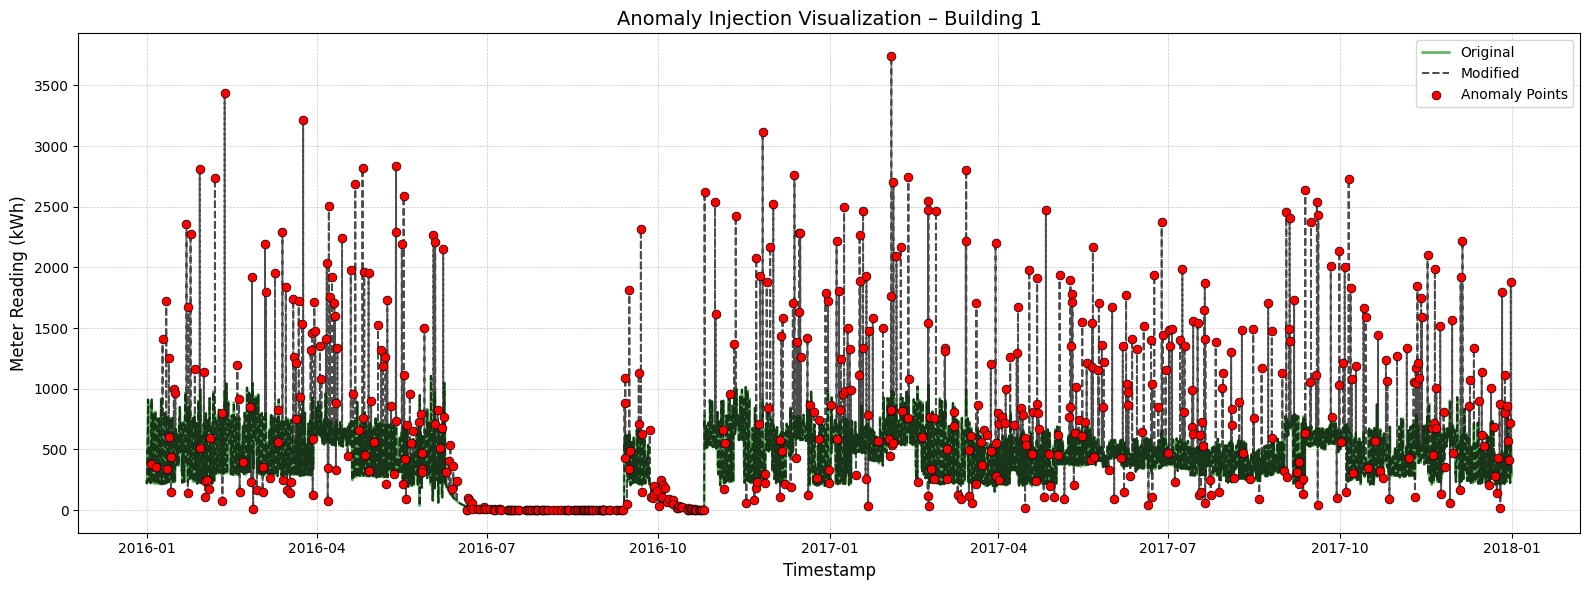

In [34]:
mod_df = pd.read_csv("OUTPUT_BDG2/MODIFIED/TYPE4/1_modified.csv") 
plot_anomaly_injection_result(mod_df, anomaly_type=4,building_id=1)

In [35]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from typing import Optional

def plot_interactive_anomaly_heatmap(
    original_df: pd.DataFrame,
    injected_df: pd.DataFrame,
    building_id: int,
    output_html_path: Optional[str] = None,
    anomaly_type: int = 2
) -> None:
    """
    Generates a side-by-side interactive heatmap comparing the imputed and anomaly-injected meter readings.

    This visualizes hourly power consumption by day of year using Plotly, highlighting anomalies through
    a heatmap colored with the 'YlOrRd' palette. Hover tooltips show both modified and original values
    with timestamps.

    Parameters
    ----------
    original_df : pd.DataFrame
        LEAD-format dataframe with columns ['timestamp', 'building_id', 'meter_reading'].
    injected_df : pd.DataFrame
        DataFrame with ['timestamp', 'original', 'modified', 'labels'].
    building_id : int
        The building to visualize.
    output_html_path : str, optional
        If set, saves the heatmap to an HTML file.

    Returns
    -------
    None
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # --- Preprocessing ---
    orig_df = original_df[original_df['building_id'] == building_id].copy()
    inj_df = injected_df.copy()
    
    # Find duplicate timestamps in injected data
    inj_df = inj_df[inj_df['timestamp'].duplicated(keep='first') == False]
    print(f"✅ Found {len(inj_df)} unique timestamps in injected data for building {building_id}")

    inj_df['timestamp'] = pd.to_datetime(inj_df['timestamp'])
    orig_df['timestamp'] = pd.to_datetime(orig_df['timestamp'])

    df = pd.merge(inj_df, orig_df[['timestamp', 'meter_reading']], on='timestamp', how='left')
    df.rename(columns={'meter_reading': 'imputed'}, inplace=True)

    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['hour'] = df['timestamp'].dt.hour
    df['timestamp_str'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

   # Robust pivot tables using pivot_table to avoid errors due to duplicates
    modified_pivot = df.pivot_table(index='hour', columns='day_of_year', values='modified', aggfunc='first')
    imputed_pivot  = df.pivot_table(index='hour', columns='day_of_year', values='imputed', aggfunc='first')
    original_pivot = df.pivot_table(index='hour', columns='day_of_year', values='original', aggfunc='first')
    timestamp_pivot = df.pivot_table(index='hour', columns='day_of_year', values='timestamp_str', aggfunc='first')

    # --- Custom hover template ---
    hover_data = []
    for hour in modified_pivot.index:
        hover_row = []
        for day in modified_pivot.columns:
            mod_val = modified_pivot.at[hour, day]
            orig_val = original_pivot.at[hour, day]
            ts = timestamp_pivot.at[hour, day]
            if pd.isna(mod_val) or pd.isna(orig_val):
                hover_row.append("No Data")
            else:
                hover_row.append(
                    f"Timestamp: {ts}<br>Modified: {mod_val:.2f}<br>Original: {orig_val:.2f}"
                )
        hover_data.append(hover_row)

    # --- Plotly Heatmaps ---
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=[
            f"Original Imputed Readings – Building {building_id}",
            f"Anomaly-Injected Readings – Building {building_id}"
        ],
        shared_yaxes=True
    )

    colorscale = 'YlOrRd'  # Heatmap gradient (Yellow → Orange → Red)

    fig.add_trace(
        go.Heatmap(
            z=imputed_pivot.values,
            x=imputed_pivot.columns,
            y=imputed_pivot.index,
            colorscale=colorscale,
            zmin=np.nanmin(imputed_pivot.values),
            zmax=np.nanmax(imputed_pivot.values),
            hovertemplate="Hour: %{y}:00<br>Day: %{x}<br>Imputed: %{z:.2f}<extra></extra>"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Heatmap(
            z=modified_pivot.values,
            x=modified_pivot.columns,
            y=modified_pivot.index,
            colorscale=colorscale,
            zmin=np.nanmin(imputed_pivot.values),
            zmax=np.nanmax(imputed_pivot.values),
            customdata=np.array(hover_data),
            hovertemplate="%{customdata}<extra></extra>"
        ),
        row=1, col=2
    )

    fig.update_layout(
        title_text=f"Hourly Heatmap of Meter Readings with Injected Anomalies of Type {anomaly_type} for Building {building_id}",
        width=1400,
        height=500,
        margin=dict(t=60, l=50, r=50, b=50)
    )

    fig.update_yaxes(title="Hour of Day", tickmode='array', tickvals=list(range(0, 24, 2)), row=1, col=1)
    fig.update_xaxes(title="Day of Year")

    if output_html_path:
        fig.write_html(output_html_path)
        print(f"✅ Saved interactive heatmap to: {output_html_path}")
        fig.show()
    else:
        fig.show()





In [36]:
imputed_df = pd.read_csv("electricity_cleaned_imputed.csv")
injected_df = pd.read_csv("OUTPUT_BDG2/MODIFIED/TYPE4/1_modified.csv")  # replace 1 with building ID

building_id = 1  # Specify the building ID you want to visualize
anomaly_type = 4  # Specify the anomaly type you want to visualize



plot_interactive_anomaly_heatmap(
    original_df=imputed_df,
    injected_df=injected_df,
    building_id=building_id,
    output_html_path= f"anomaly_heatmap_building_{building_id}_type_{anomaly_type}.html",  # Save to HTML
    anomaly_type=anomaly_type
)


✅ Found 17544 unique timestamps in injected data for building 1
✅ Saved interactive heatmap to: anomaly_heatmap_building_1_type_4.html
